In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA, PLSRegression
import adaptive_latents as al
# from nlb_tools.nwb_interface import NWBDataset
from pynwb import NWBHDF5IO
import pandas as pd
from collections import namedtuple
import adaptive_latents
from functools import lru_cache
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

rng = np.random.default_rng()

In [2]:
fpath = al.CONFIG["data_path"] / '000128'/ 'sub-Jenkins'/ 'sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb'

nwb_in = NWBHDF5IO(fpath, "r").read()

In [3]:
trials = nwb_in.intervals['trials'].to_dataframe()
trial_types = trials["trial_type"].unique()

hand_pos = np.array(nwb_in.processing['behavior'].data_interfaces['hand_pos'].data)
hand_t = np.array(nwb_in.processing['behavior'].data_interfaces['hand_pos'].timestamps)

units = nwb_in.units.to_dataframe()

In [4]:
def intersection(start1, stop1, start2, stop2):
    return max(min(stop1, stop2) - max(start1, start2),0)

@lru_cache(maxsize=None)
def make_experiment_slice(start_time, stop_time, bin_width=0.03):
    bin_edges = np.arange(start_time, stop_time, bin_width)
    
    A = np.zeros((len(bin_edges)-1, units.shape[0]))
    
    for i in range(units.shape[0]):
        A[:,i], _ = np.histogram(units.iloc[i,1], bin_edges)

    recorded_intervals = units.iloc[0,2]
    interval_to_start_from = 0
    for i in range(len(bin_edges)-1):
        bin_start = bin_edges[i]
        bin_stop = bin_edges[i+1]
        covered = 0
        for j in range(interval_to_start_from, recorded_intervals.shape[0]):
            interval_start, interval_stop = recorded_intervals[j]
            if bin_start > interval_stop:
                interval_to_start_from += 1
                continue
            if interval_start > bin_stop:
                break
            covered +=  intersection(bin_start, bin_stop, interval_start, interval_stop)
            
        if covered/bin_width < .9:
            A[i,:] = np.nan
    
    bin_centers = np.convolve(bin_edges,[.5, .5],'valid')
    beh = adaptive_latents.input_sources.functional.resample_behavior(hand_pos, bin_centers, hand_t)
    beh[:,1] -= -33
    beh[:,0] -= -2
    return namedtuple('ExperementSlice', ['A', 'beh', 'bin_centers'])(A, beh, bin_centers)


def get_slices_for_set(trial_type_index, trial_version, selected_set=None):
    if selected_set is None:
        selected_set = trials[(trials.trial_type == trial_types[trial_type_index]) & (trials.trial_version == trial_version)]

    ret = []
    for index, row in selected_set.iterrows():
        slice = make_experiment_slice(row.start_time, row.stop_time, bin_width=0.03)
        ret.append(slice)
    return ret

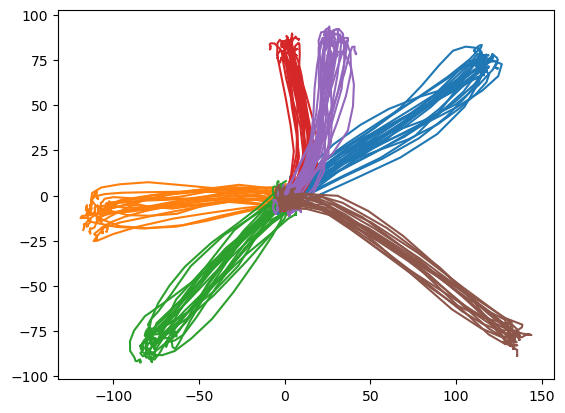

In [5]:
fig, ax = plt.subplots()

for i in range(6):
    for slice in get_slices_for_set(trial_type_index=i, trial_version=0, selected_set=None):
        ax.plot(slice.beh[:,0], slice.beh[:,1], f"C{i}")
# ax.plot(reach[:,0], reach[:,1], 'C1', label=f"type_idx {trial_type_index} version {trial_version}")
# ax.legend()

In [6]:
def make_to_regression_variables(slices):
    A = None
    beh = None
    t = []
    for sub_A, sub_beh, sub_t in slices:
        A = np.vstack([A, sub_A]) if np.any(A) else sub_A
        beh = np.vstack([beh, sub_beh]) if np.any(beh) else sub_beh
        t = np.hstack([t,sub_t])

    no_nan_rows = np.all(np.isfinite(np.hstack([A, beh, t[:,None]])), axis=1)
    A = A[no_nan_rows,:]
    beh = beh[no_nan_rows,:]
    t = t[no_nan_rows]
    
    return A, beh, t


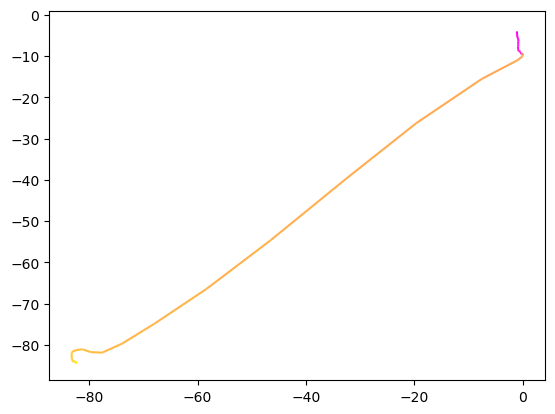

In [10]:
# https://stackoverflow.com/a/25941474
def plot_with_time(ax, x, time=None):
    if time is None:
        time = np.linspace(0,1, x.shape[0])
    time -= min(time)
    time /= max(time)
    points = x.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = matplotlib.collections.LineCollection(segments, array=time, cmap=plt.get_cmap('spring'))
    ranges = np.array([[min(x[:,0]), max(x[:,0])],
              [min(x[:,1]), max(x[:,1])]])
    centers = ranges.mean(axis=1)
    out = ((ranges[:,1] - ranges[:,0])/2) * 1.1
    frame = np.array([centers - out, centers + out]).T

    curr_xlim = ax.get_xlim()
    ax.set_xlim([min(frame[0,0], curr_xlim[0]), max(frame[0,1], curr_xlim[1])])
    curr_ylim = ax.get_ylim()
    ax.set_ylim([min(frame[1,0], curr_ylim[0]), max(frame[1,1], curr_ylim[1])])

    ax.add_collection(lc)
    
fig,ax = plt.subplots()
plot_with_time(ax, slice.beh, slice.bin_centers)
# ax.set_xlim([-80,20])
# ax.set_ylim([-80,20])
plt.show()

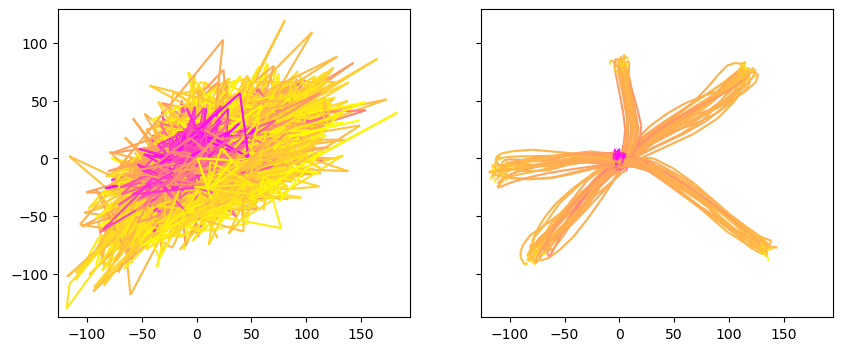

In [12]:
slices = get_slices_for_set(2,0) + get_slices_for_set(0,0) + get_slices_for_set(1,0) + get_slices_for_set(3,0) + get_slices_for_set(5,0)
A, beh, t = make_to_regression_variables(slices)

reg = LinearRegression()
reg.fit(A, beh)
# beta, residuals, rank, s = np.linalg.lstsq(A, beh, rcond=None)

fig, axs = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)

for slice in slices:
    recon = reg.predict(slice.A)
    plot_with_time(axs[0], recon, time=slice.bin_centers)
    plot_with_time(axs[1], slice.beh, time=slice.bin_centers)


555.9519900150119


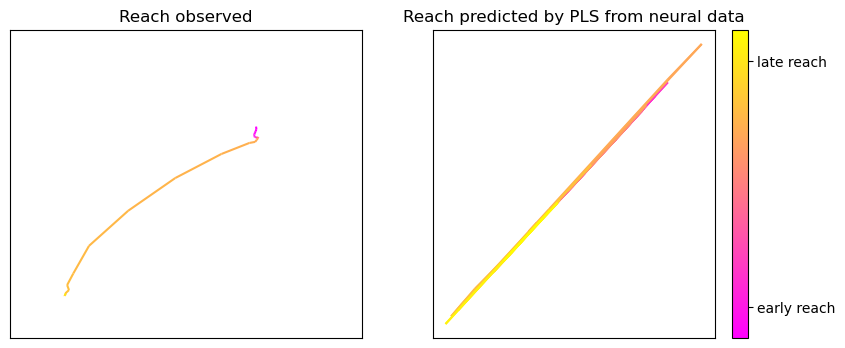

In [14]:
slices = get_slices_for_set(2,0) #+ get_slices_for_set(0,0) + get_slices_for_set(1,0) + get_slices_for_set(3,0) + get_slices_for_set(5,0)
train, test = train_test_split(slices, test_size = 1)
A, beh, t = make_to_regression_variables(train)

# reg = CCA()
reg = PLSRegression()
# reg = LinearRegression()

reg.fit(A, beh)

fig, axs = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)

SE = [0,0]
for slice in test:
    recon = reg.predict(slice.A)
    SE[0] += ((recon - slice.beh)**2).sum()
    SE[1] += recon.size
    plot_with_time(axs[1], recon, time=slice.bin_centers)
    plot_with_time(axs[0], slice.beh, time=slice.bin_centers)
    
print(SE[0]/SE[1])
axs[1].set_title("Reach predicted by PLS from neural data")
axs[0].set_title("Reach observed")
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(plt.Normalize(0,1),cmap=plt.get_cmap('spring')), ax=axs[1])

cbar.set_ticks([.1,.9])
cbar.set_ticklabels(["early reach","late reach"])
axs[0].set_xticks([])
axs[0].set_yticks([]);

In [ ]:
np.array([x, y])

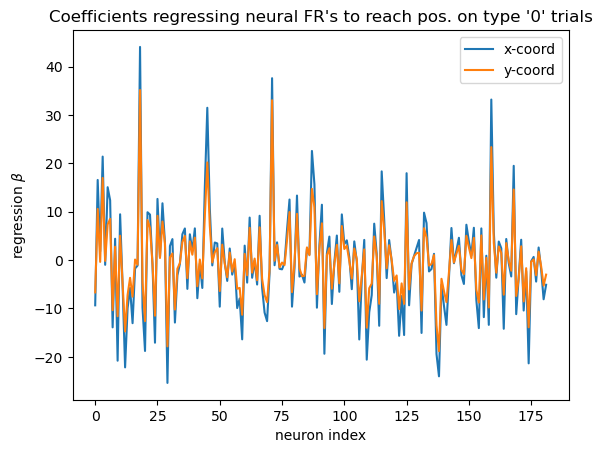

In [12]:
fig, ax = plt.subplots()
ax.plot(beta, '-', label=["x-coord", 'y-coord'])
ax.set_xlabel("neuron index")
ax.set_ylabel("regression $\\beta$")
ax.legend()
ax.set_title(f"Coefficients regressing neural FR's to reach pos. on type '{trial_type_index}' trials");

In [13]:
cca = CCA(n_components=2)
cca.fit(sanitized_A, sanitized_beh)

CCA()

In [14]:
cca.transform(sanitized_A)

array([[-0.09554539, -2.66745484],
       [-1.10196322, -2.31682971],
       [-0.07369553, -1.66787865],
       ...,
       [ 1.56523563,  2.59435708],
       [ 0.80222984,  1.0005606 ],
       [ 2.12686359,  0.10520105]])

In [15]:
sanitized_A @ cca.- cca.transform(sanitized_A)

SyntaxError: invalid syntax (2765426430.py, line 1)

In [ ]:
reconstructed_reaches = sanitized_A @ cca.coef_.T + cca.intercept_
plt.plot(*reconstructed_reaches.T)

(-90.0, 20.0)

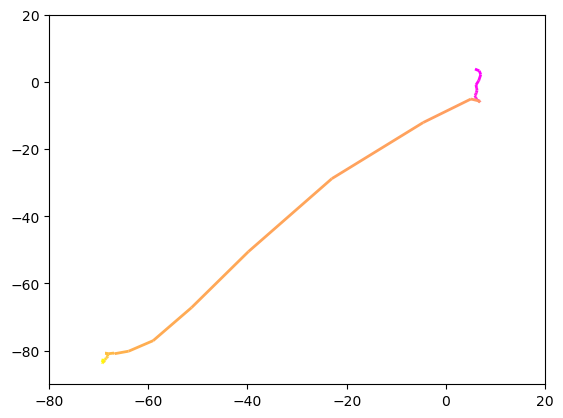

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

N = 10
np.random.seed(101)
x = np.random.rand(N)
y = np.random.rand(N)
fig, ax = plt.subplots()
plt.style.use('default')

# path = mpath.Path(np.column_stack([x, y]))
# verts = path.interpolated(steps=3).vertices
x, y = slice.beh.T
z = np.linspace(0, 1, len(x))
colorline(x, y, z, cmap=plt.get_cmap('spring'), linewidth=2)
ax.set_xlim([-80, 20])
ax.set_ylim([-90, 20])